In [180]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import re
from pathlib import Path
import brody as bd
from scipy.ndimage import gaussian_filter

matplotlib.rcParams['figure.figsize'] = [10,7]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['font.family'] = 'DejaVu Serif'
matplotlib.rcParams['mathtext.default'] = 'regular'

## Recon Dataframe format

We have 655 reconstructed events per SNe event, all in a single dataframe. We have 500 SnE
events altogether, written to files int the format `recon_<number>.h5`, where \<number\> is
the run number with 6 digits.

In [281]:
paths = sorted(Path("/nfs/disk1/youngsam/sims/2023-03-21_SNe").glob("recon_*.h5"))
print("Found {} files".format(len(paths)))
bd.File(paths[0], "r")

Found 233 files


/nfs/disk1/youngsam/sims/2023-03-21_SNe/recon_000000.h5/
├cosalpha	[float64: 655]
├eDir	[float64: 655 × 3]
├eKE	[float64: 655]
├flavor	[int64: 655]
├nuEnergy	[float64: 655]
├recon	[float64: 655 × 7]
├sn_direction	[float64: 3]
└truth	[float64: 655 × 7]

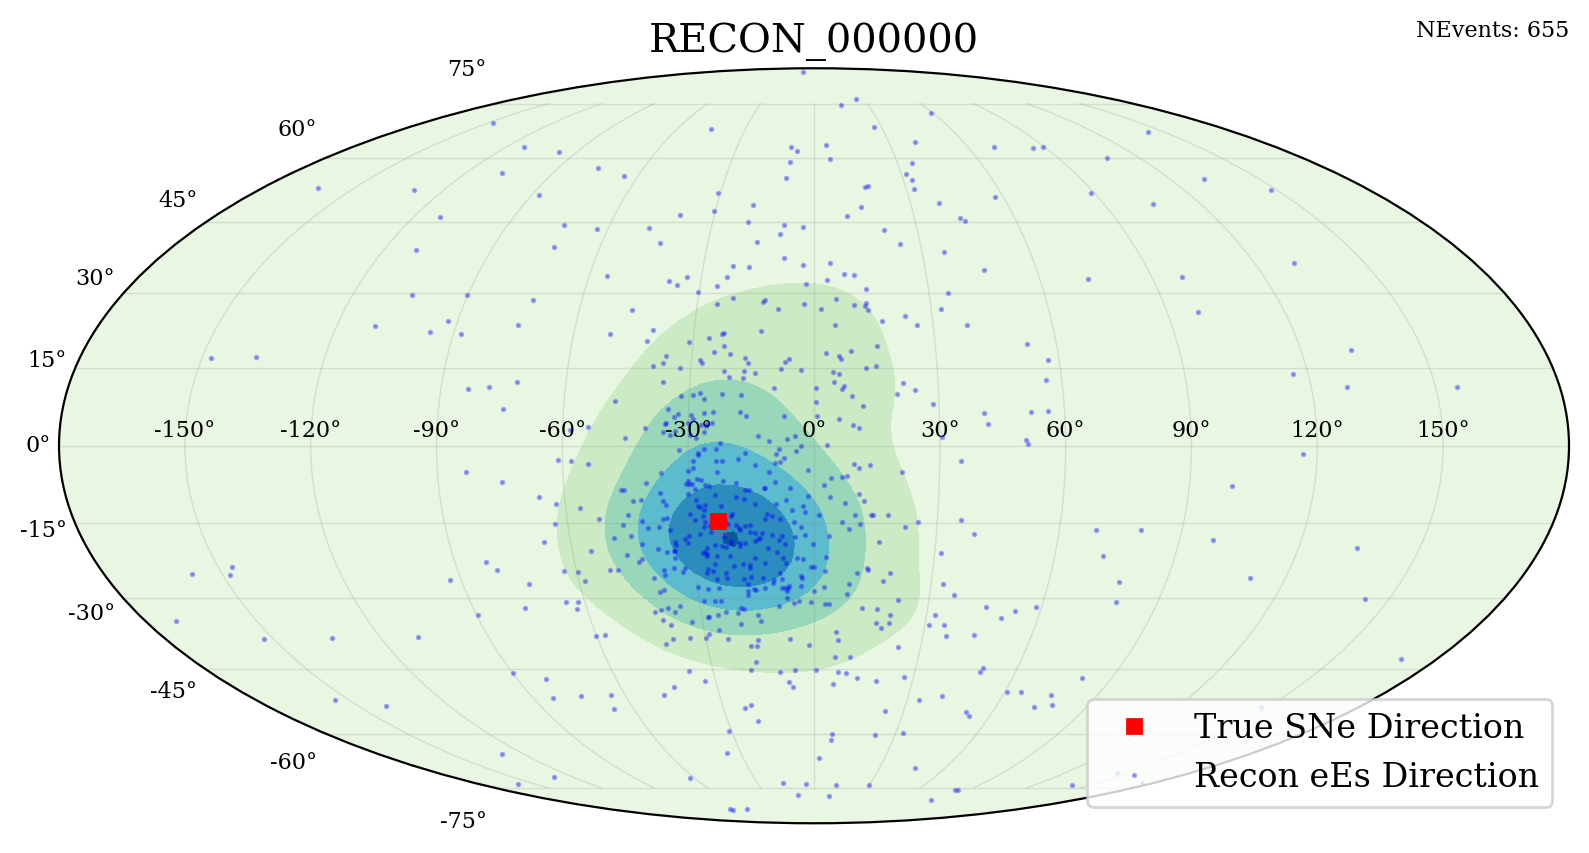

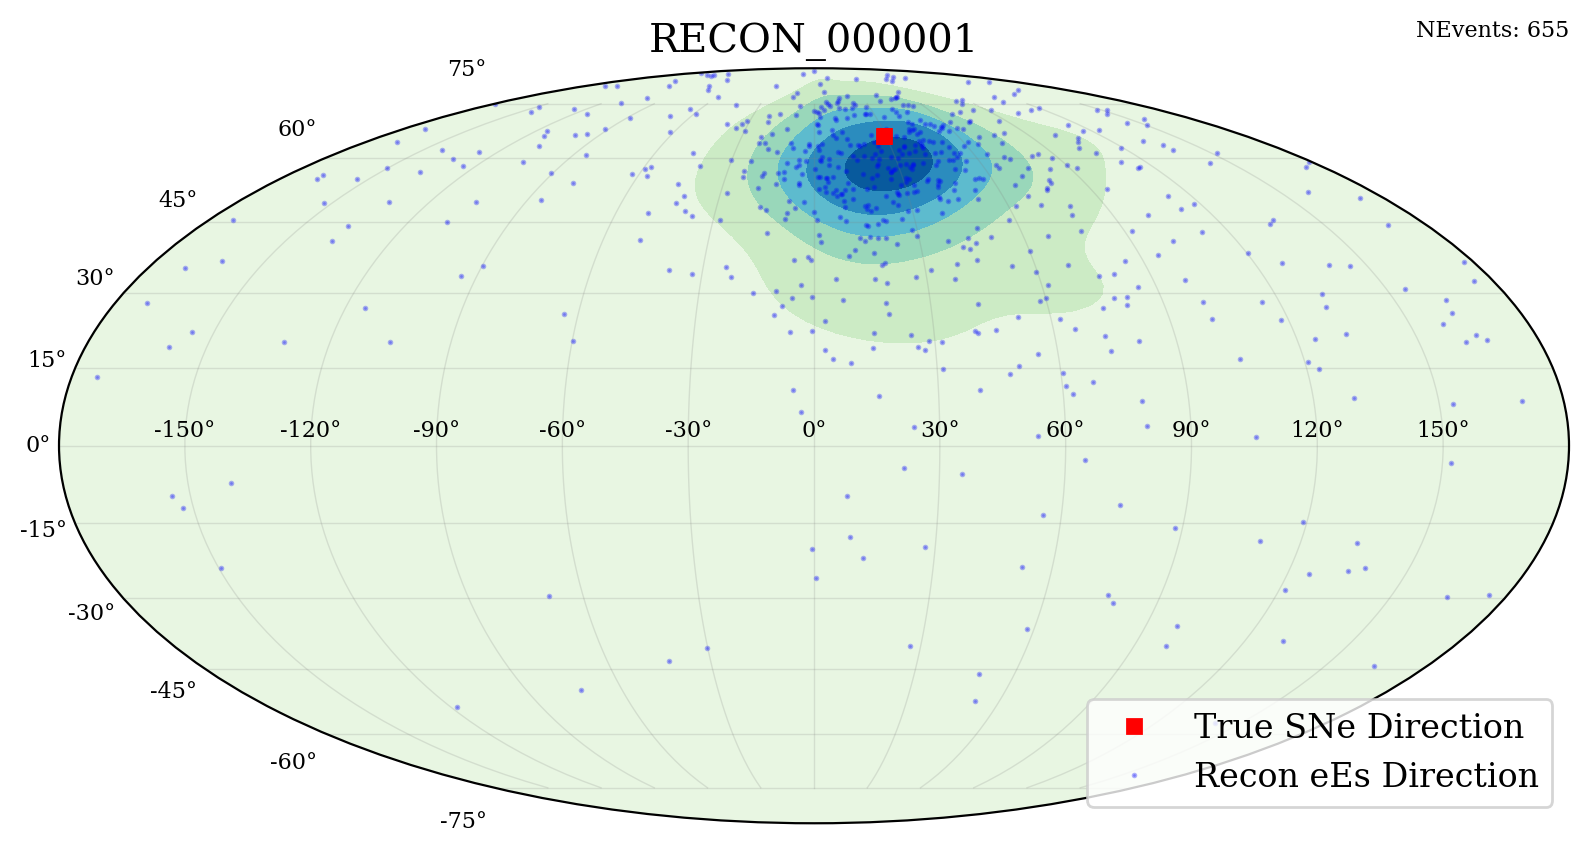

In [302]:
def cart2sph(x, y, z):
    theta = np.arccos(z)
    phi = np.arctan2(y, x)
    return phi, theta - np.pi/2  # [-pi, pi], [-np.pi/2, pi/2]

def prepare_xyz(df):
    """Failed fits have -999 for x,y,z, so remove those"""
    df = np.atleast_2d(df[:].copy())
    x,y,z = df.T
    isnan = np.logical_or.reduce([x==-999, y==-999, z==-999])
    x,y,z = x[~isnan], y[~isnan], z[~isnan]
    phi, theta = cart2sph(x,y,z)
    return phi, theta

def contourf(ax, phi, theta, **kwargs):
    """Plot a contour of the 2D histogram of phi, theta."""
    sigma = kwargs.pop("sigma", 4)
    bins = kwargs.pop("bins", 100)

    # histogram
    H, X, Y = np.histogram2d(phi, theta, bins, range=[[-np.pi, np.pi], [-np.pi/2, np.pi/2]])
    # bin centers
    XE, YE = (X[1:] + X[:-1])/2, (Y[1:] + Y[:-1])/2
    # smooth so the contour isn't crazy
    H = gaussian_filter(H, sigma)
    ax.contourf(XE, YE, H.T, **kwargs)
    

def plot_df(filename, /, save=False):
    """Plot the reconstructed and true event directions."""
    run_number = re.search(r"recon_(\d+).h5", str(filename)).group(1)
    df = bd.File(filename, "r")
    
    fig = plt.figure(figsize=(10, 5), dpi=200)
    ax = fig.add_subplot(111, projection="mollweide")
    ax.grid(True, zorder=-999, alpha=0.2, color="grey", lw=0.5)
    ax.set_axisbelow(True)

    # convert from cartesian to spherical coordinates
    rphi, rtheta   = prepare_xyz(df['recon'][:, 4:7])
    tphi, ttheta   = prepare_xyz(df['sn_direction'])
    
    # true SNe direction
    ax.plot(tphi, ttheta, 's', color='red', markersize=5, alpha=1, zorder=999, label='True SNe Direction')
    # -- reconstructed event directions
    ax.plot(rphi, rtheta, 'o', color='blue', markersize=1, alpha=0.3, label="Recon eEs Direction")
    #    contour
    contourf(ax, rphi, rtheta, bins=100, levels=5, cmap='GnBu', alpha=1, zorder=-999)
    
    # true event directions
    # tsphi, tstheta = prepare_xyz(df['truth'][:, 4:7])
    # ax.plot(tsphi, tstheta, 'o', color='red', markersize=1, alpha=0.1, label='True eES Direction', zorder=-999)
    
    # plot nhit
    ax.text(1, 1.05, f"NEvents: {df['cosalpha'].len()}", ha='right', va='center', fontsize=8, zorder=999,
            transform=ax.transAxes)
    
    
    plt.title(f"RECON_{run_number}", )
    ax.tick_params(axis="both", which="both", labelsize=8, zorder=-999)
    ax.set_facecolor("#E8F6E2")
    ax.legend(loc='lower right')
    if save:
        out_dir = filename.parent / "images"
        out_dir.mkdir(exist_ok=True)
        plt.savefig(out_dir / f"recon_{run_number}.jpg", dpi=300, bbox_inches='tight')
    plt.show()

plot_df(paths[0], save=True)
plot_df(paths[1])
